In [2]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette="pastel")
from collections import Counter
from itertools import combinations
import bitermplus as btm
import tmplot as tmp
import re
import tweepy
import requests
import numpy as np

In [3]:
work_dir = "D:/OneDrive - Otto-Friedrich-Universität Bamberg/Master/Masterarbeit/Data"

In [6]:
tweets_df = pd.read_csv(work_dir + "/Twitter/all_tweets.csv")

In [7]:
print(tweets_df.shape)

(48278, 5)


In [8]:
tweets_df['date'] = pd.to_datetime(tweets_df['date'], errors='coerce')


In [9]:
tweets_df = tweets_df[(tweets_df['date'] > "2020-07-08")]



In [10]:
print(tweets_df.shape)
print(tweets_df["tweet"])

(23713, 5)
0        @kkklawitter @EggMarkus @sepp_reitberger Das e...
1        amperio GmbH: mobileeee und amperio starten la...
2        Zur Ladeinfrastruktur für Elektrofahrzeuge geh...
3        @chris_pyak @JRehborn @HerrPhteven Dazu noch n...
4        @Mingiam10 @kkklawitter Mein Punkt ist ja der ...
                               ...                        
23708    @Solarfighter @BMWi_Bund @peteraltmaier @BAFA_...
23709    @Solarfighter @peteraltmaier @BAFA_Bund Der Au...
23710    #Tesla hat mit der Eröffnung des neuen #Superc...
23711    @danjol_lupardo @Canstatt93 @Poveretto Das ist...
23712    @BMWi_Bund @peteraltmaier @BAFA_Bund Weit und ...
Name: tweet, Length: 23713, dtype: object


In [11]:
# calculate Tweet sentiment

analyzer = SentimentIntensityAnalyzer()
def calculate_sentiment(dataframe):
    utf_encoded = dataframe["tweet"].encode('utf-16', 'surrogatepass').decode('utf-16')
    vs = analyzer.polarity_scores(utf_encoded)
    neg_list.append(vs["neg"])
    neu_list.append(vs["neu"])
    pos_list.append(vs["pos"])
    com_list.append(vs["compound"])
    return dataframe

In [12]:
neg_list = []
neu_list = []
pos_list = []
com_list = []
tweets_df = tweets_df.apply(lambda x: calculate_sentiment(x), axis=1)

In [13]:
tweets_df["negative"] = neg_list
tweets_df["neutral"] = neu_list
tweets_df["positive"] = pos_list
tweets_df["compound"] = com_list

In [14]:
print(tweets_df)

       Unnamed: 0                      date             user  \
0               0 2022-04-26 08:44:26+00:00   ReinerKurzmann   
1               1 2022-04-26 08:44:03+00:00  na_presseportal   
2               2 2022-04-26 08:40:02+00:00     SmartHomeEU1   
3               3 2022-04-26 08:32:54+00:00       EPhisoloph   
4               4 2022-04-26 08:26:51+00:00           Amie42   
...           ...                       ...              ...   
23708       23708 2020-07-08 06:52:18+00:00    J_Hildermeier   
23709       23709 2020-07-08 06:40:56+00:00             BMWK   
23710       23710 2020-07-08 06:30:25+00:00     ElectriveNet   
23711       23711 2020-07-08 04:29:36+00:00         kamil2_0   
23712       23712 2020-07-08 04:23:03+00:00          MAZirke   

                                                   tweet  \
0      @kkklawitter @EggMarkus @sepp_reitberger Das e...   
1      amperio GmbH: mobileeee und amperio starten la...   
2      Zur Ladeinfrastruktur für Elektrofahrzeuge g

In [15]:
def assign_sentiment(row):
    float_compound = float(row['compound'])
    if float_compound >= 0.05:
        val = 'Positive'
    elif float_compound <= -0.05:
        val = 'Negative'
    else:
        val = 'Neutral'
    return val

In [16]:
tweets_df['sentiment'] = tweets_df.apply(assign_sentiment, axis=1)

In [17]:
tweet_sentiment = tweets_df.groupby(['sentiment']).size()

positive = tweet_sentiment['Positive']
neutral = tweet_sentiment['Neutral']
negative = tweet_sentiment['Negative']

labels = ['Positive', 'Neutral', 'Negative' ]
sentiment_count = [positive, neutral, negative]

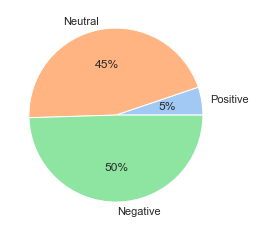

In [18]:
plt.pie(sentiment_count, labels = labels, autopct='%.0f%%')
plt.show()

In [19]:
print(tweets_df["user"])

0         ReinerKurzmann
1        na_presseportal
2           SmartHomeEU1
3             EPhisoloph
4                 Amie42
              ...       
23708      J_Hildermeier
23709               BMWK
23710       ElectriveNet
23711           kamil2_0
23712            MAZirke
Name: user, Length: 23713, dtype: object


In [20]:
unique_users = tweets_df["user"].unique()

user_df = pd.DataFrame(unique_users, columns = ['users'])

follower_count = []

for user in unique_users:
    str_user = str(user)
    request_link = "https://cdn.syndication.twimg.com/widgets/followbutton/info.json?screen_names="+str_user
    
    try:
        request_result = requests.get(request_link).json()
    except:
        request_result = None
    
    try:
        follower = int(request_result[0]["followers_count"])
    except:
        follower = None
    
    follower_count.append(follower)

user_df["follower_count"] = follower_count

In [21]:
print(tweets_df['user'].value_counts())

SmartHomeEU1    957
ElectriveNet    688
emobicon        453
stang2k         197
news_nowgmbh    132
               ... 
optikfluffel      1
tomul             1
mitsuhiko         1
sarfeld           1
MAZirke           1
Name: user, Length: 9351, dtype: int64


In [23]:
print(user_df['follower_count'].sum())

45192865.0


In [34]:
user_df['follower_count'] = user_df['follower_count'].fillna('').astype(str).str.replace(".0","",regex=False)
print(user_df['follower_count'])

0        114
1       6641
2        977
3         11
4        598
        ... 
9346       5
9347    2000
9348     711
9349    1033
9350     387
Name: follower_count, Length: 9351, dtype: object


In [36]:
user_df.to_csv("users_with_followers.csv")

In [38]:
print(user_df)

                users follower_count
0      ReinerKurzmann            114
1     na_presseportal           6641
2        SmartHomeEU1            977
3          EPhisoloph             11
4              Amie42            598
...               ...            ...
9346       chaase1337              5
9347     Stefan_Urbat           2000
9348    J_Hildermeier            711
9349         kamil2_0           1033
9350          MAZirke            387

[9351 rows x 2 columns]


In [39]:
unique_users = user_df['users'].tolist()

In [54]:
print(len(unique_users))

split_users = np.array_split(unique_users, 100)
print(split_users[0])

9351
ReinerKurzmann


In [61]:
bearer_token = "AAAAAAAAAAAAAAAAAAAAAOR%2BbwEAAAAASwiLtwOgXt%2FtG0EJIrLdaph2Xsw%3DspW7CHN0I6KBcjdy4BVvj75LpMAdgQ5l3DIkrcVWMFz8FLIHlz"

client = tweepy.Client(bearer_token, wait_on_rate_limit=True)

user_id = []
user_name = []
for chunk in split_users:
    users = ",".join(chunk)

    response = client.get_users(usernames=users)

    for user in response.data:
        user_id.append(user.id)
        user_name.append(user.username)

new_user_df = pd.DataFrame(user_id, columns = ['user_id'])
new_user_df["user_name"] = user_name

Rate limit exceeded. Sleeping for 546 seconds.


In [62]:
print(new_user_df)
print(user_df)

                  user_id        user_name
0               372243368   ReinerKurzmann
1                44894572  na_presseportal
2     1254490069299322882     SmartHomeEU1
3     1251959965209841664       EPhisoloph
4               212992615           Amie42
...                   ...              ...
9319           3075117101       chaase1337
9320             59542471     Stefan_Urbat
9321           3068639057    J_Hildermeier
9322             14829549         kamil2_0
9323           4739156727          MAZirke

[9324 rows x 2 columns]
                users follower_count
0      ReinerKurzmann            114
1     na_presseportal           6641
2        SmartHomeEU1            977
3          EPhisoloph             11
4              Amie42            598
...               ...            ...
9346       chaase1337              5
9347     Stefan_Urbat           2000
9348    J_Hildermeier            711
9349         kamil2_0           1033
9350          MAZirke            387

[9351 rows x 2

In [63]:
merged_user_df = pd.merge(user_df, new_user_df, left_on='users', right_on='user_name', how='left')

In [77]:
merged_user_df["user_id"] = merged_user_df["user_id"].astype('Int64')

In [80]:
print(merged_user_df)

     follower_count              user_id        user_name
0               114            372243368   ReinerKurzmann
1              6641             44894572  na_presseportal
2               977  1254490069299322880     SmartHomeEU1
3                11  1251959965209841664       EPhisoloph
4               598            212992615           Amie42
...             ...                  ...              ...
9346              5           3075117101       chaase1337
9347           2000             59542471     Stefan_Urbat
9348            711           3068639057    J_Hildermeier
9349           1033             14829549         kamil2_0
9350            387           4739156727          MAZirke

[9351 rows x 3 columns]


In [81]:
merged_user_df.to_csv("merged_user.csv")

In [99]:
# Topic Modelling

# Remove punctuation
tweets_df['tweet_processed'] = tweets_df['tweet'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
tweets_df['tweet_processed'] = tweets_df['tweet'].map(lambda x: x.lower())

tweets = tweets_df['tweet_processed'].str.strip().tolist()

# PREPROCESSING
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
tweets_X, tweets_vocabulary, tweets_vocab_dict = btm.get_words_freqs(tweets)
tweets_tf = np.array(tweets_X.sum(axis=0)).ravel()

In [100]:
# Vectorizing documents
tweets_docs_vec = btm.get_vectorized_docs(tweets, tweets_vocabulary)
tweets_docs_lens = list(map(len, tweets_docs_vec))

In [101]:
# Generating title biterms
tweets_biterms = btm.get_biterms(tweets_docs_vec)

In [102]:
# Initializing and running titles model
def btm_model(topics, alpha, beta):
    tweets_model = btm.BTM(
        tweets_X, tweets_vocabulary, seed=12321, T=topics, M=5, alpha=alpha, beta=beta)
    tweets_model.fit(tweets_biterms, iterations=20)
    tweets_p_zd = tweets_model.transform(tweets_docs_vec)
    
    return tweets_model

def Average(l): 
    avg = sum(l) / len(l) 
    return avg

In [103]:
# Determening the number of topics by running the model with a fixed alpha = 0.01 and beta = 0.1
coherence_list = []
perplexity_list = []
# Topics range
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

for k in topics_range:
    # get the coherence score for the given parameters
    model = btm_model(k, 0.1, 0.1)
            
    perplexity = model.perplexity_
    coherence = model.coherence_
    
    coherence_list.append(Average(coherence))
    perplexity_list.append(perplexity)

100%|█████████████████████████████████████████████████████████████████████████| 23713/23713 [00:01<00:00, 21542.77it/s]


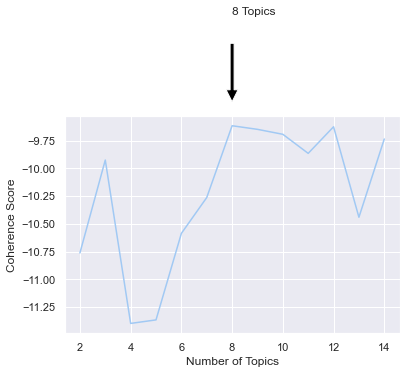

8 -9.615524489328465


In [104]:
ymax = max(coherence_list)
ymax_string = str(ymax)
xpos = coherence_list.index(ymax)
xmax = topics_range[xpos]
xmax_string = str(xmax)
plt.plot(topics_range, coherence_list)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.annotate(xmax_string + ' Topics' , xy=(xmax, ymax), xytext=(xmax, ymax+1),
            arrowprops=dict(facecolor='black', shrink=0.22),
            )
plt.show()

print(xmax, ymax)

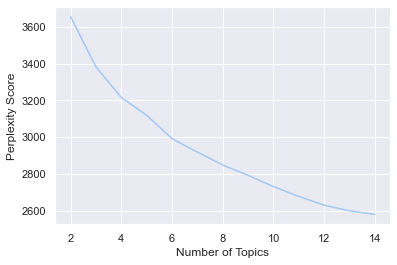

In [105]:
plt.plot(topics_range, perplexity_list)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.show()

In [106]:
# Topic parameter 
k = 8
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))

model_results = {'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplexity': []
                }


# iterate through alpha values
for a in alpha:
    # iterare through beta values
    for b in beta:
        # get the coherence score for the given parameters
        model = btm_model(k, a, b)
            
        perplexity = model.perplexity_
        coherence = model.coherence_
            
        # Save the model results
        model_results['Alpha'].append(a)
        model_results['Beta'].append(b)
        model_results['Coherence'].append(Average(coherence))
        model_results['Perplexity'].append(perplexity)

100%|█████████████████████████████████████████████████████████████████████████| 23713/23713 [00:00<00:00, 26371.20it/s]


In [107]:
benchmark_df = pd.DataFrame(model_results)
print(benchmark_df)

benchmark_df.to_csv("benchmark.csv", index=False)

    Alpha  Beta  Coherence   Perplexity
0    0.01  0.01  -9.162313  3662.855913
1    0.01  0.31  -9.644494  2535.168049
2    0.01  0.61 -10.392308  2396.530163
3    0.01  0.91 -10.354925  2329.340579
4    0.31  0.01  -9.162313  3660.852523
5    0.31  0.31  -9.644494  2533.796215
6    0.31  0.61 -10.392308  2395.830157
7    0.31  0.91 -10.354925  2329.490433
8    0.61  0.01  -9.162313  3660.386199
9    0.61  0.31  -9.644494  2538.187799
10   0.61  0.61 -10.392308  2394.109076
11   0.61  0.91 -10.354925  2329.603872
12   0.91  0.01  -9.162313  3659.712782
13   0.91  0.31  -9.644494  2538.857303
14   0.91  0.61 -10.392308  2396.391753
15   0.91  0.91 -10.582920  2328.015445


In [109]:
# Choosen highest coherence with a trade-off for a higher perplexity because of a higher semantic correlation to make it easier to interpret
tweets_model = btm.BTM(
tweets_X, tweets_vocabulary, seed=12321, T=8, M=5, alpha=0.01, beta=0.01)
tweets_model.fit(tweets_biterms, iterations=20)
tweets_p_zd = tweets_model.transform(tweets_docs_vec)

100%|█████████████████████████████████████████████████████████████████████████| 23713/23713 [00:00<00:00, 24459.59it/s]


In [110]:
p_zd = tweets_model.transform(tweets_docs_vec)

100%|█████████████████████████████████████████████████████████████████████████| 23713/23713 [00:00<00:00, 25223.59it/s]


In [124]:
words_topics_df = tweets_model.df_words_topics_

words_topics_0 = pd.DataFrame(words_topics_df[0])
words_topics_0["word"] = words_topics_df.index

words_topics_1 = pd.DataFrame(words_topics_df[1])
words_topics_1["word"] = words_topics_df.index

words_topics_2 = pd.DataFrame(words_topics_df[2])
words_topics_2["word"] = words_topics_df.index

words_topics_3 = pd.DataFrame(words_topics_df[3])
words_topics_3["word"] = words_topics_df.index

words_topics_4 = pd.DataFrame(words_topics_df[4])
words_topics_4["word"] = words_topics_df.index

words_topics_5 = pd.DataFrame(words_topics_df[5])
words_topics_5["word"] = words_topics_df.index

words_topics_6 = pd.DataFrame(words_topics_df[6])
words_topics_6["word"] = words_topics_df.index

words_topics_7 = pd.DataFrame(words_topics_df[7])
words_topics_7["word"] = words_topics_df.index

                  0       word
die        0.035481        die
der        0.033102        der
und        0.027327        und
in         0.018923         in
das        0.017049        das
ladesäule  0.015758  ladesäule
an         0.014937         an
ist        0.014718        ist
mit        0.013606        mit
den        0.013583        den


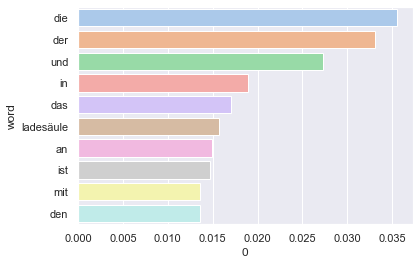

In [113]:
top_0 = words_topics_0.nlargest(10, 0)

print(top_0)
ax = sns.barplot(x=0, y="word", data=top_0)

                          1               word
die                0.040486                die
der                0.036763                der
und                0.031188                und
ladeinfrastruktur  0.021461  ladeinfrastruktur
für                0.020387                für
in                 0.019667                 in
das                0.019186                das
ist                0.012872                ist
den                0.012735                den
zu                 0.010962                 zu


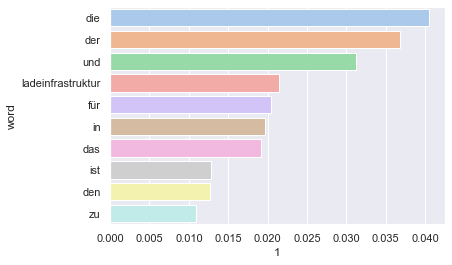

In [119]:
top_1 = words_topics_1.nlargest(10, 1)

print(top_1)
ax = sns.barplot(x=1, y="word", data=top_1)

                          2               word
der                0.040838                der
die                0.038684                die
und                0.030345                und
in                 0.029479                 in
für                0.027923                für
ladeinfrastruktur  0.023860  ladeinfrastruktur
mit                0.014543                mit
das                0.013227                das
den                0.012575                den
von                0.011236                von


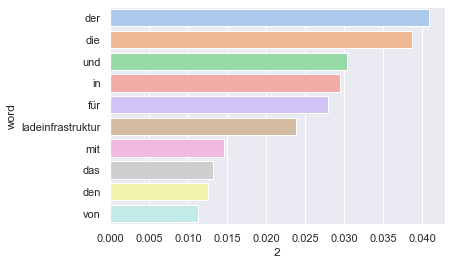

In [122]:
top_2 = words_topics_2.nlargest(10, 2)
print(top_2)
ax = sns.barplot(x=2, y="word", data=top_2)

                  3       word
die        0.031661        die
der        0.029110        der
und        0.024053        und
ladesäule  0.020017  ladesäule
das        0.017754        das
ist        0.017623        ist
nicht      0.014913      nicht
in         0.014782         in
mit        0.014507        mit
ich        0.014047        ich


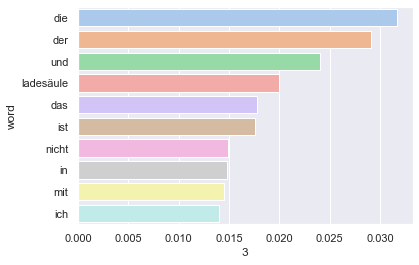

In [123]:
top_3 = words_topics_3.nlargest(10, 3)
print(top_3)
ax = sns.barplot(x=3, y="word", data=top_3)

                          4               word
der                0.044849                der
die                0.039606                die
für                0.030825                für
ladeinfrastruktur  0.026459  ladeinfrastruktur
und                0.025833                und
von                0.024992                von
mit                0.022590                mit
in                 0.020260                 in
den                0.014669                den
sie                0.012184                sie


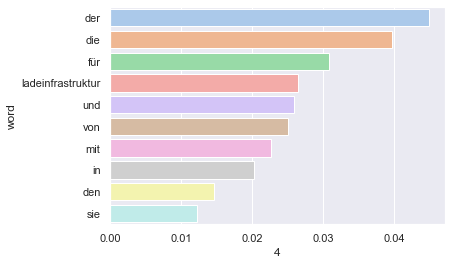

In [125]:
top_4 = words_topics_4.nlargest(10, 4)
print(top_4)
ax = sns.barplot(x=4, y="word", data=top_4)

                  5       word
und        0.071728        und
der        0.061392        der
schneider  0.044862  schneider
electric   0.043861   electric
für        0.041371        für
von        0.035151        von
ein        0.030699        ein
eine       0.029212       eine
zur        0.028530        zur
gemeinsam  0.025543  gemeinsam


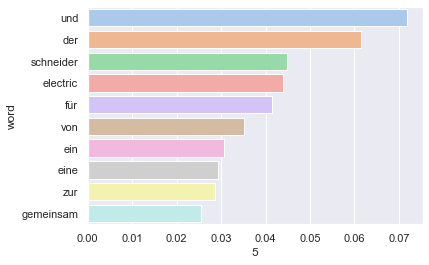

In [126]:
top_5 = words_topics_5.nlargest(10, 5)
print(top_5)
ax = sns.barplot(x=5, y="word", data=top_5)

                  6       word
ich        0.030119        ich
die        0.027114        die
ladesäule  0.025813  ladesäule
der        0.021857        der
und        0.021710        und
das        0.019559        das
nicht      0.017973      nicht
ist        0.017233        ist
es         0.014686         es
an         0.013961         an


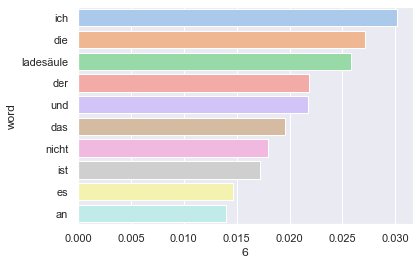

In [127]:
top_6 = words_topics_6.nlargest(10, 6)
print(top_6)
ax = sns.barplot(x=6, y="word", data=top_6)

                          7               word
die                0.040822                die
und                0.026206                und
der                0.023540                der
ladeinfrastruktur  0.017496  ladeinfrastruktur
in                 0.017156                 in
das                0.015958                das
zu                 0.015817                 zu
für                0.015171                für
es                 0.014823                 es
nicht              0.014570              nicht


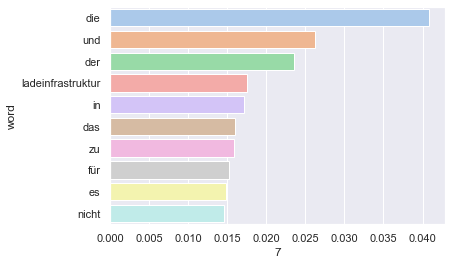

In [132]:
top_7 = words_topics_7.nlargest(10, 7)
print(top_7)
ax = sns.barplot(x=7, y="word", data=top_7)

In [136]:
top_words = btm.get_top_topic_words(
    tweets_model,
    words_num=100)


top_words_df = pd.DataFrame(top_words)
print(top_words_df.head())

top_docs = btm.get_top_topic_docs(
    tweets_df['tweet_processed'],
    p_zd,
    docs_num=3783,
    topics_idx=[0,1,2,3])

top_docs_df = pd.DataFrame(top_docs)
print(top_docs_df.head())

top_words_df.to_csv("top_words.csv", index=False)

  topic0             topic1 topic2     topic3             topic4     topic5  \
0    die                die    der        die                der        und   
1    der                der    die        der                die        der   
2    und                und    und        und                für  schneider   
3     in  ladeinfrastruktur     in  ladesäule  ladeinfrastruktur   electric   
4    das                für    für        das                und        für   

      topic6             topic7  
0        ich                die  
1        die                und  
2  ladesäule                der  
3        der  ladeinfrastruktur  
4        und                 in  
                                              topic0  \
0  entwicklungsingenieur hil-testing backend-lade...   
1  @p_humm apropos ladeinfrastruktur: schon geseh...   
2  #alphastruxure kürt #themobilityhouse zum tech...   
3  #eswewiesbaden - wunsch-e-ladesäule gegen tank...   
4  walther ladesäule ecolectra 250 m2 m.2

In [141]:
tweet_topics = btm.get_docs_top_topic(tweets, tweets_model.matrix_docs_topics_)

print(tweet_topics.head())

tweet_topics.to_csv("tweets_topics.csv")

                                           documents  label
0  @kkklawitter @eggmarkus @sepp_reitberger das e...      1
1  amperio gmbh: mobileeee und amperio starten la...      0
2  zur ladeinfrastruktur für elektrofahrzeuge geh...      5
3  @chris_pyak @jrehborn @herrphteven dazu noch n...      6
4  @mingiam10 @kkklawitter mein punkt ist ja der ...      0


In [4]:
tweets_df = pd.read_csv(work_dir + "/Twitter/all_tweets.csv")

In [5]:
# Hier Stopwörter entfernen + kleingeschrieben, dann Model nochmal neu aufstellen - Problem: Entfernung funktioniert nicht

# Topic Modelling
# Convert the titles to lowercase
tweets_df['tweet_processed'] = tweets_df['tweet'].map(lambda x: x.lower())
print(tweets_df['tweet_processed'])

# Remove punctuation and stopwords

banned = ["der", "die", "das", "und", "in", "an", "zu", "für", "es", "von", "den", "dem", ",", ".", "!", "?", "/"]
f = lambda x: ' '.join([item for item in x.split() if item not in banned])
tweets_df["tweet_processed"] = tweets_df["tweet_processed"].apply(f)

print(tweets_df['tweet_processed'])
tweets = tweets_df['tweet_processed'].str.strip().tolist()

# PREPROCESSING
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
tweets_X, tweets_vocabulary, tweets_vocab_dict = btm.get_words_freqs(tweets)
tweets_tf = np.array(tweets_X.sum(axis=0)).ravel()

0        @kkklawitter @eggmarkus @sepp_reitberger das e...
1        amperio gmbh: mobileeee und amperio starten la...
2        zur ladeinfrastruktur für elektrofahrzeuge geh...
3        @chris_pyak @jrehborn @herrphteven dazu noch n...
4        @mingiam10 @kkklawitter mein punkt ist ja der ...
                               ...                        
48273    elektroautos: japanische autobauer entwickeln ...
48274    elektroautos: japanische autobauer entwickeln ...
48275    elektroautos: japanische autobauer entwickeln ...
48276    elektroautos: japanische autobauer entwickeln ...
48277    mcdonalds goes e-mobility - #mcdonalds und der...
Name: tweet_processed, Length: 48278, dtype: object
0        @kkklawitter @eggmarkus @sepp_reitberger einzi...
1        amperio gmbh: mobileeee amperio starten langfr...
2        zur ladeinfrastruktur elektrofahrzeuge gehört ...
3        @chris_pyak @jrehborn @herrphteven dazu noch n...
4        @mingiam10 @kkklawitter mein punkt ist ja park...
    

In [6]:
# Vectorizing documents
tweets_docs_vec = btm.get_vectorized_docs(tweets, tweets_vocabulary)
tweets_docs_lens = list(map(len, tweets_docs_vec))

In [7]:
# Generating title biterms
tweets_biterms = btm.get_biterms(tweets_docs_vec)

In [8]:
# Initializing and running titles model
def btm_model(topics, alpha, beta):
    tweets_model = btm.BTM(
        tweets_X, tweets_vocabulary, seed=12321, T=topics, M=5, alpha=alpha, beta=beta)
    tweets_model.fit(tweets_biterms, iterations=20)
    tweets_p_zd = tweets_model.transform(tweets_docs_vec)
    
    return tweets_model

def Average(l): 
    avg = sum(l) / len(l) 
    return avg

In [9]:
# Initializing and running titles model
def btm_model(topics, alpha, beta):
    tweets_model = btm.BTM(
        tweets_X, tweets_vocabulary, seed=12321, T=topics, M=5, alpha=alpha, beta=beta)
    tweets_model.fit(tweets_biterms, iterations=20)
    tweets_p_zd = tweets_model.transform(tweets_docs_vec)
    
    return tweets_model

def Average(l): 
    avg = sum(l) / len(l) 
    return avg

In [10]:
# Determening the number of topics by running the model with a fixed alpha = 0.01 and beta = 0.1
coherence_list = []
perplexity_list = []
# Topics range
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

for k in topics_range:
    # get the coherence score for the given parameters
    model = btm_model(k, 0.1, 0.1)
            
    perplexity = model.perplexity_
    coherence = model.coherence_
    
    coherence_list.append(Average(coherence))
    perplexity_list.append(perplexity)

100%|█████████████████████████████████████████████████████████████████████████| 48278/48278 [00:01<00:00, 44619.26it/s]


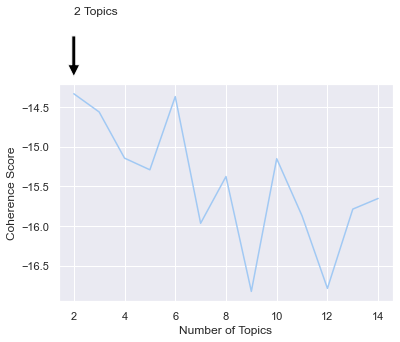

2 -14.333022751693864


In [11]:
ymax = max(coherence_list)
ymax_string = str(ymax)
xpos = coherence_list.index(ymax)
xmax = topics_range[xpos]
xmax_string = str(xmax)
plt.plot(topics_range, coherence_list)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.annotate(xmax_string + ' Topics' , xy=(xmax, ymax), xytext=(xmax, ymax+1),
            arrowprops=dict(facecolor='black', shrink=0.22),
            )
plt.show()

print(xmax, ymax)

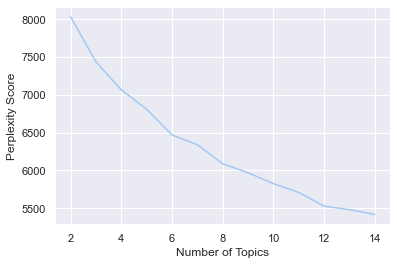

In [12]:
plt.plot(topics_range, perplexity_list)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.show()

In [13]:
# Topic parameter 
k = 2
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))

model_results = {'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplexity': []
                }


# iterate through alpha values
for a in alpha:
    # iterare through beta values
    for b in beta:
        # get the coherence score for the given parameters
        model = btm_model(k, a, b)
            
        perplexity = model.perplexity_
        coherence = model.coherence_
            
        # Save the model results
        model_results['Alpha'].append(a)
        model_results['Beta'].append(b)
        model_results['Coherence'].append(Average(coherence))
        model_results['Perplexity'].append(perplexity)

100%|█████████████████████████████████████████████████████████████████████████| 48278/48278 [00:00<00:00, 65592.53it/s]


In [14]:
benchmark_df = pd.DataFrame(model_results)
print(benchmark_df)

benchmark_df.to_csv("benchmark-2.csv", index=False)

    Alpha  Beta  Coherence    Perplexity
0    0.01  0.01 -14.482025  11078.954083
1    0.01  0.31 -15.109681   6902.433432
2    0.01  0.61 -15.250897   6335.749423
3    0.01  0.91 -15.250897   6038.789924
4    0.31  0.01 -14.482025  11078.954072
5    0.31  0.31 -15.109681   6902.433422
6    0.31  0.61 -15.250897   6335.749411
7    0.31  0.91 -15.250897   6038.789912
8    0.61  0.01 -14.482025  11078.954061
9    0.61  0.31 -15.109681   6902.433412
10   0.61  0.61 -15.250897   6335.749400
11   0.61  0.91 -15.250897   6038.789622
12   0.91  0.01 -14.482025  11078.954050
13   0.91  0.31 -15.109681   6902.432335
14   0.91  0.61 -15.250897   6335.749389
15   0.91  0.91 -15.250897   6038.794956


In [15]:
# Choosen highest coherence with a trade-off for a higher perplexity because of a higher semantic correlation to make it easier to interpret
tweets_model = btm.BTM(
tweets_X, tweets_vocabulary, seed=12321, T=2, M=5, alpha=0.01, beta=0.01)
tweets_model.fit(tweets_biterms, iterations=20)
tweets_p_zd = tweets_model.transform(tweets_docs_vec)

100%|█████████████████████████████████████████████████████████████████████████| 48278/48278 [00:00<00:00, 63605.33it/s]


In [16]:
p_zd = tweets_model.transform(tweets_docs_vec)

100%|█████████████████████████████████████████████████████████████████████████| 48278/48278 [00:00<00:00, 64974.89it/s]


In [17]:
words_topics_df = tweets_model.df_words_topics_

words_topics_0 = pd.DataFrame(words_topics_df[0])
words_topics_0["word"] = words_topics_df.index

words_topics_1 = pd.DataFrame(words_topics_df[1])
words_topics_1["word"] = words_topics_df.index

                          0               word
ladesäule          0.022803          ladesäule
ich                0.019483                ich
nicht              0.018741              nicht
ist                0.018631                ist
mit                0.016788                mit
auch               0.013515               auch
eine               0.013032               eine
ladeinfrastruktur  0.011945  ladeinfrastruktur
man                0.010697                man
ein                0.010317                ein


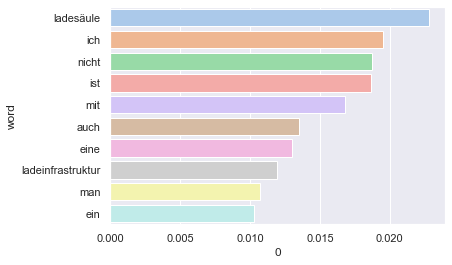

In [18]:
top_0 = words_topics_0.nlargest(10, 0)

print(top_0)
ax = sns.barplot(x=0, y="word", data=top_0)

                          1               word
ladeinfrastruktur  0.031330  ladeinfrastruktur
mit                0.019435                mit
ist                0.015590                ist
eine               0.015486               eine
ein                0.013107                ein
im                 0.012625                 im
auf                0.012081                auf
zur                0.009976                zur
ladesäule          0.009726          ladesäule
wir                0.008273                wir


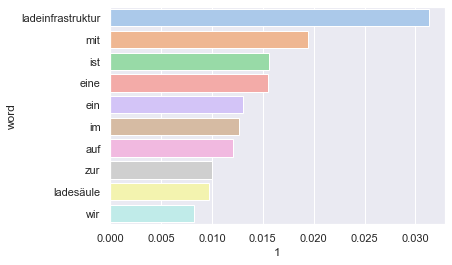

In [19]:
top_1 = words_topics_1.nlargest(10, 1)

print(top_1)
ax = sns.barplot(x=1, y="word", data=top_1)

In [21]:
top_words = btm.get_top_topic_words(
    tweets_model,
    words_num=100)


top_words_df = pd.DataFrame(top_words)
print(top_words_df.head())

top_docs = btm.get_top_topic_docs(
    tweets_df['tweet_processed'],
    p_zd,
    docs_num=3783,
    topics_idx=[0,1])

top_docs_df = pd.DataFrame(top_docs)
print(top_docs_df.head())

top_words_df.to_csv("top_words-2topics.csv", index=False)

      topic0             topic1
0  ladesäule  ladeinfrastruktur
1        ich                mit
2      nicht                ist
3        ist               eine
4        mit                ein
                                              topic0  \
0  ladeinfrastruktur, batterietechnologien elektr...   
1  ladeinfrastruktur, batterietechnologien elektr...   
2  „e-auto-ladeinfrastruktur“, köln, deutschland,...   
3  charge@night #gruenesaeule #chemnitz #heos. sa...   
4  @unionista 👍 genau, ladesäule, 4 stunden parkd...   

                                              topic1  
0  ladeinfrastruktur: np-problem #elektromobilitä...  
1  schnellladegesetz beschlossen: rechtsgrundlage...  
2  #ladeinfrastruktur #ladesäulen cobe: modularer...  
3  dobrindt erwägt millionenschwere #ladeinfrastr...  
4  dobrindt erwägt millionenschwere ladeinfrastru...  


In [50]:
tweet_topics = btm.get_docs_top_topic(tweets, tweets_model.matrix_docs_topics_)

tweet_topics.to_csv("tweets_topics-2topics.csv")